# Introduction to the high accuracy positioning with open PPP/PPP-RTK services 

## Introduction to CSSRlib

*CSSRLIB* is a open toolkit in Python for high accuracy GNSS positioning. It supports SSR (State-Space Representation) based potitioning such as PPP (Precise Point Positioning) or PPP-RTK (Realtime Kinematic), but also supporting RTK. The goal of the CSSRlib toolkit is to provide an easy-to-understand open implementation to learn PPP/PPP-RTK positioning provided by satellite-based open PPP/PPP-RTK services such as QZSS CLAS, Galileo HAS, BeiDou 3 PPP. It also supports ground based open service by IGS. The code is based on RTKlib.

It supports the following open format:

- The obserbation data and the ephemeis in RINEX
- The PPP/PPP-RTK correction data in RTCM SSR, IGS SSR, Compact SSR, ...
- The precise orbit/clock data in SP3 format.


## Instration

You can install CSSRlib using pip.

```
pip install cssrlib
```

dditional python packages are required as prerequisites and can be installed via the following commands:

```
pip install notebook, numpy, matplotlib
pip install bitstruct,cbitstruct,galois,cartopy
```

To show this tutorial, Jupter Notebook should be started:

```
jupyter notebook
```

## Structure of CSSRlib


CSSRlib consits of multiple python files/modules as follows:

- Contructor (`__init__`): initialize the variables used in CSSRlib.
- `gnss`: Common subroutines and classes used in CSSRlib.
- `ephemeris`: calculate the position of satellite using ephemeris.
- `peph`: calculate the position of satellite using precise ephemeris in SP3 format．
- `tlesim`: calculate the position of satellite using TLE.
- `plot`: subroutines to visualize.

- `rinex`: parse RINEX obs/nav file.
- `cssrlib`: parse PPP/PPP-RTK correction messages in Compact SSR (CSSR) format.
- `ppp_has`: parse PPP correction messages in Galileo HAS format.
- `ppp_bds`: parse PPP correction messages in BDS-3 PPP format.

- `pntpos`: standalone positioning
- `rtk`: RTK positioning
- `ppprtk`: PPP-RTK positioning
- `ppp`: functions for PPP positioning
- `pppigs`: standard PPP positioning


## Examples

This tutorial shows the examples to show the basic features of CSSRlib, PPP/PPP-RTK/RTK positioning using correction data from open PPP/PPP-RTK services. The following examples will be included:

- Visualizing orbit of QZSS satellite
- Standalone positioning
- RTK positioning
- PPP-RTK positioning
- PPP positioning

### Visualizing Orbit of QZSS Satellite

In the first example, it will introduce the basic feature of CSSRlib to calculate and visalize the satellite orbit.

At first, we will load the required Python modules such as NumPy, Matplotlib, Cartopy. Then we will load modules in CSSRlib.

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

from cssrlib.rinex import rnxdec
from cssrlib.gnss import Nav, epoch2time, prn2sat, uGNSS, sat2prn,\
    timeadd, ecef2pos
from cssrlib.ephemeris import findeph, eph2pos

In CSSRlib, the epoch is defined as Python Class `gtime_t` as in RTKlib. The snipet defines epoch "19/3/2021 0:00:00", shows the internal variable of `gtime_t`.

In [8]:
t0 = epoch2time([2021, 3, 19, 0, 0, 0]) # year, month, day, hour, minute, sec
t0.time,t0.sec

(1616112000, 0)

Then, the ephemeris in RINEX format is loaded using RINEX decoder in CSSRlib.

In [9]:
dec = rnxdec()
nav = dec.decode_nav( '../data/30340780.21q', Nav()) # load RINEX navigation file

The satellite is identified by the system (GPS, Galileo, QZS, ...) and PRN number, it should be converted into the internal satellite number using `prn2sat`. The snippet shows the satellite number for QZSS with PRN 194 (QZS-2):

In [24]:
sat = prn2sat(uGNSS.QZS, 194)
sat

157

The orbit position of GNSS satellite can be calculated using ephemeris defined in RINEX navigation file. The valid ephemeris at specific epoch can be searched using `findeph`, position/velocity in ECEF and clock bias are calculated by `eph2pos`. The position in geodetic cordinates can be calculated by `ecef2pos`:

In [20]:
t = t0
eph = findeph(nav.eph, t, sat)
rs, vs, dts = eph2pos(t, eph, True)
print('rs=',rs, 'vs=', vs,'dts=', dts)
pos = ecef2pos(rs)
print('pos=',pos)

rs= [-27695465.67390223  25576355.5431149   23733383.2869802 ] vs= [ 618.82498925 -271.15881898 1281.49729409] dts= 3.4869334074196084e-06
pos= [5.62300943e-01 2.39595272e+00 3.81752334e+07]


The orbit of QZS-2 in 1 days (24 hours) is calculated and plotted using Cartopy:

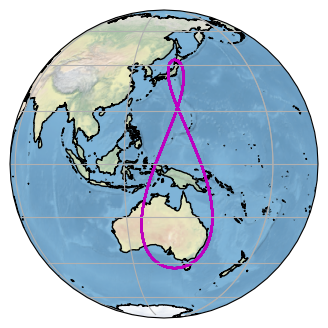

In [16]:
lon0 = 135
plt.figure(figsize=(4, 4))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=lon0,
                                           central_latitude=0))
ax.coastlines(resolution='50m')
ax.gridlines()
ax.stock_img()

n = 24*3600//300
pos = np.zeros((n, 3))
r2d = 180/np.pi

for k in range(uGNSS.MAXSAT):
    sat = k+1
    sys, prn = sat2prn(sat)
    if sys != uGNSS.QZS:  # skip non QZSS
        continue
    for i in range(n):
        t = timeadd(t0, i*300)
        if eph is None:
            continue
        rs, dts = eph2pos(t, eph)
        pos[i, :] = ecef2pos(rs)

    plt.plot(pos[:, 1]*r2d, pos[:, 0]*r2d, 'm-', transform=ccrs.Geodetic())
plt.show()

## Showing Skyplot

For the visualization of measurement, CSSRlib supports the skyplot of satellte orbit path at specific location. At first, the required modules are loaded.

In [10]:
import numpy as np
from cssrlib.gnss import Nav, ecef2pos, geodist, satazel, timediff, uGNSS
from cssrlib.ephemeris import findeph, eph2pos
from cssrlib.plot import skyplot, plot_elv
from cssrlib.rinex import rnxdec

Then, An instance of RINEX decoder is generated. In this example, the observation and navigation files measured by Septentrio Mosaic-X5 are used.

In [11]:
navfile = '../data/SEPT078M.21P'
obsfile = '../data/SEPT078M.21O'

dec = rnxdec()
nav = dec.decode_nav(navfile,Nav())

Next, the orbit of tracked satellites is calculated for 15 minutes of epoch.

In [12]:
nep = 15*60
elv = np.ones((nep, uGNSS.MAXSAT))*np.nan
azm = np.ones((nep, uGNSS.MAXSAT))*np.nan
t = np.zeros(nep)*np.nan

if dec.decode_obsh(obsfile) >= 0:
    rr = dec.pos
    pos = ecef2pos(rr)
    for ne in range(nep):
        obs = dec.decode_obs()
        if ne == 0:
            t0 = obs.t
        t[ne] = timediff(obs.t, t0)
        for k, sat in enumerate(obs.sat):
            eph = findeph(nav.eph, obs.t, sat)
            if eph is None:
                continue
            rs, dts = eph2pos(obs.t, eph)
            r, e = geodist(rs, rr)
            azm[ne, sat-1], elv[ne, sat-1] = satazel(pos, e)
    dec.fobs.close()

The elevation and azimuth angle of satellite are recorded, and skyplot is generated as bellow:

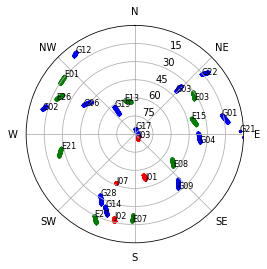

In [13]:
#plot_elv(t, elv)
nsat = skyplot(azm, elv)

## Standalone positioning

This section introduces the standalone GNSS positioning using RINEX observation. At first, Python modules are loaded.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from cssrlib.rinex import rnxdec
from cssrlib.gnss import ecef2pos, timediff, dops, ecef2enu
from cssrlib.pntpos import stdinit, pntpos

The rover position is defined for reference.

In [18]:
xyz_ref = [-3962108.673,   3381309.574,   3668678.638]
pos_ref = ecef2pos(xyz_ref)

RINEX navigation and obeservation files are defined, an instance of RINEX decoder is generated.

In [16]:
navfile = '../data/SEPT078M.21P'
obsfile = '../data/SEPT078M.21O'
dec = rnxdec()
nav = dec.decode_nav(navfile, stdinit())

The variables for position, DOPs, number of satellite are defined for 6 minutes epoch.

In [19]:
nep = 6*60
t = np.zeros(nep)
enu = np.zeros((nep, 3))
sol = np.zeros((nep, nav.nx))
dop = np.zeros((nep, 4))
nsat = np.zeros(nep, dtype=int)

The standalone GNSS positioning by `pntpos()` is conducted for 6 minutes.

In [20]:
if dec.decode_obsh(obsfile) >= 0:
    nav.x[0:3] = dec.pos
    for ne in range(nep):
        obs = dec.decode_obs()
        if ne == 0:
            t0 = nav.t = obs.t
        t[ne] = timediff(obs.t, t0)
        nav, az, el = pntpos(obs, nav)
        sol[ne, :] = nav.x
        dop[ne, :] = dops(az, el)
        enu[ne, :] = ecef2enu(pos_ref, sol[ne, 0:3]-xyz_ref)
        nsat[ne] = len(el)
    dec.fobs.close()

The ENU position relative to the reference position is plotted.

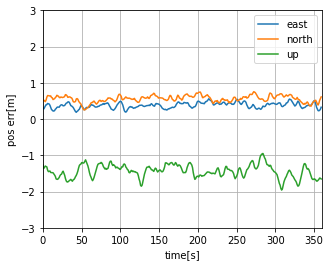

In [25]:
dmax = 3
plt.figure(figsize=(5,4))
plt.plot(t, enu)
plt.ylabel('pos err[m]')
plt.xlabel('time[s]')
plt.legend(['east', 'north', 'up'])
plt.grid()
plt.axis([0, nep, -dmax, dmax])
plt.show()

To measure the geomtry for positioning, DOPs (PDOP, HDOP, VDOP) are plotted:

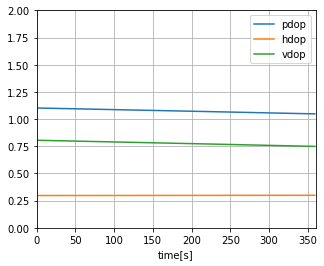

In [26]:
plt.figure(figsize=(5,4))
plt.plot(t, dop[:, 1:])
plt.legend(['pdop', 'hdop', 'vdop'])
plt.grid()
plt.axis([0, nep, 0, 2])
plt.xlabel('time[s]')
plt.show()

## RTK positioning

This section describes RTK positioning. At first the Python modules are loaded.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import cssrlib.rinex as rn
import cssrlib.gnss as gn
from cssrlib.rtk import rtkinit, relpos

The reference position of rover is defined for evaulation.

In [28]:
xyz_ref = [-3962108.673,   3381309.574,   3668678.638]
pos_ref = gn.ecef2pos(xyz_ref)

The measurement and ephemeris data on rover (Septentrio Mosaic-X5) are loaded.

In [30]:
bdir = '../data/'
navfile = bdir+'SEPT078M.21P'
obsfile = bdir+'SEPT078M.21O'

# rover
dec = rn.rnxdec()
nav = gn.Nav()
dec.decode_nav(navfile, nav)
ret = dec.decode_obsh(obsfile)

For RTK positioning, the observation file on base station need to be prepared. The position of base station is also defined.

In [31]:
# base
# GSI 3034 fujisawa
basefile = bdir+'3034078M.21O'
nav.rb = [-3959400.631, 3385704.533, 3667523.111]
decb = rn.rnxdec()
ret = decb.decode_obsh(basefile)

The variables for position are initialized. RTK parameters are also initialized.

In [32]:
nep = 60
t = np.zeros(nep)
enu = np.zeros((nep, 3))
smode = np.zeros(nep, dtype=int)

rtkinit(nav, dec.pos)
rr = dec.pos

RTK positioning is conducted for 60 seconds (epochs) using `relpos()`. 

In [33]:
for ne in range(nep):
    obs, obsb = rn.sync_obs(dec, decb)
    if ne == 0:
        t0 = nav.t = obs.t
    relpos(nav, obs, obsb)
    t[ne] = gn.timediff(nav.t, t0)
    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = gn.ecef2enu(pos_ref, sol-xyz_ref)
    smode[ne] = nav.smode

dec.fobs.close()
decb.fobs.close()

The relative position with reference position is plotted.

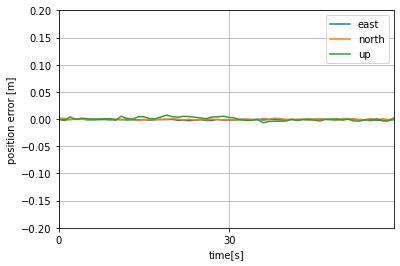

In [34]:
ylim = 0.2
plt.plot(t, enu)
plt.xticks(np.arange(0, nep+1, step=30))
plt.ylabel('position error [m]')
plt.xlabel('time[s]')
plt.legend(['east', 'north', 'up'])
plt.grid()
plt.axis([0, ne, -ylim, ylim])
plt.show()

## PPP-RTK positioning

This section shows PPP-RTK positioning using QZSS CLAS. At first the required Python modules are loaded.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cssrlib.gnss as gn
import sys
from cssrlib.cssrlib import cssr
from cssrlib.gnss import ecef2pos, Nav, time2gpst, timediff
from cssrlib.ppprtk import rtkinit, ppprtkpos
from cssrlib.rinex import rnxdec

Then, RINEX observation and navigation files are defined.

In [2]:
navfile = '../data/SEPT078M.21P'
obsfile = '../data/SEPT078M.21O'

dec = rnxdec()
nav = Nav()
nav = dec.decode_nav(navfile, nav)

For the reference, the rover position based on GSI F5 solution is defined.

In [3]:
# based on GSI F5 solution
xyz_ref = [-3962108.673,   3381309.574,   3668678.638]
pos_ref = ecef2pos(xyz_ref)

QZSS CLAS correction messages are encoded in Compact SSR format. In this example, the recorded L6 data ( doy 078 in 2021, session M) is used. The grid position of QZSS CLAS defined in IS-QZSS-L6 is also loaded.

In [10]:
l6file = '../data/2021078M.l6'
griddef = '../data/clas_grid.def'
cs = cssr()
cs.monlevel = 1
cs.week = 2149
cs.read_griddef(griddef)

The variables for 3 minutes (epochs) are defined.

In [11]:
nep = 3*60

t = np.zeros(nep)
tc = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
dop = np.zeros((nep, 4))
smode = np.zeros(nep, dtype=int)

PPP-RTK positioning using `ppprtkpos()` is conducted for 3 minutes. QZSS L6 messages are encoded in sub-frames (5 second per sub-frame), for the simple implementation, the recorded data is decoded in ebry 5 seconds.

In [12]:
if dec.decode_obsh(obsfile) >= 0:
    rr = dec.pos
    rtkinit(nav, dec.pos)
    pos = ecef2pos(rr)
    inet = cs.find_grid_index(pos)

    fc = open(l6file, 'rb')
    if not fc:
        print("L6 messsage file cannot open.")
        sys.exit(-1)

    for ne in range(nep):
        obs = dec.decode_obs()
        week, tow = time2gpst(obs.t)

        cs.decode_l6msg(fc.read(250), 0)
        if cs.fcnt == 5:  # end of sub-frame
            cs.week = week
            cs.decode_cssr(cs.buff, 0)

        if ne == 0:
            t0 = nav.t = obs.t
            t0.time = t0.time//30*30
            cs.time = obs.t
            nav.time_p = t0

        cstat = cs.chk_stat()
        if cstat:
            ppprtkpos(nav, obs, cs)

        t[ne] = timediff(nav.t, t0)
        tc[ne] = timediff(cs.time, t0)

        sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
        enu[ne, :] = gn.ecef2enu(pos_ref, sol-xyz_ref)
        smode[ne] = nav.smode

    fc.close()
    dec.fobs.close()
if nav.fout is not None:
    nav.fout.close()

RTK mode status (4: fix, 5: float, 0: no-solution) is defined for plotting.

In [14]:
idx4 = np.where(smode == 4)[0]
idx5 = np.where(smode == 5)[0]
idx0 = np.where(smode == 0)[0]

The relative position with reference position is plotted. After receiving QZSS CLAS correction message within 30 seconds, the position is instatenously fixed, it shows RTK-like performance.

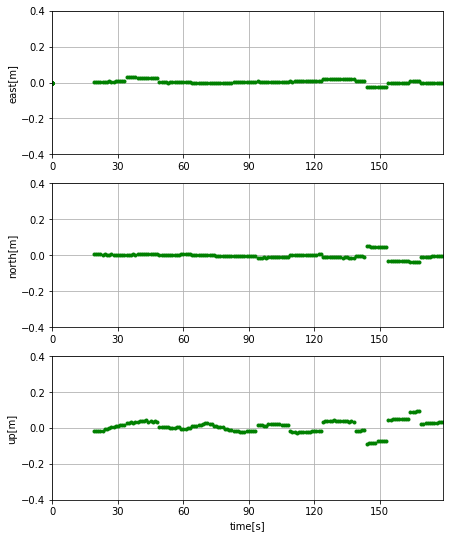

In [15]:
ylim = 0.4
fig = plt.figure(figsize=[7, 9])
lbl_t = ['east[m]', 'north[m]', 'up[m]']
for k in range(3):
    plt.subplot(3, 1, k+1)
    plt.plot(t[idx0], enu[idx0, k], 'r.')
    plt.plot(t[idx5], enu[idx5, k], 'y.')
    plt.plot(t[idx4], enu[idx4, k], 'g.')

    plt.xticks(np.arange(0, nep+1, step=30))
    if k == 2:
        plt.xlabel('time[s]')
    plt.ylabel(lbl_t[k])
    plt.grid()
    plt.axis([0, ne, -ylim, ylim])
plt.show()

## PPP positioning

(TBD)

## Reference

- [1] T. Takasu, “RTKLIB: Open Source Program Package for RTK-GPS,” FOSS4G 2009 Tokyo, Japan, 2009.